## Gaussian Mixture Model using EM

To measure the quality of a given run (dependent on randomly initialized parameters), use the variational <u>lower bound</u>:

$$\mathcal{L} = \sum_{i=1}^{N} \sum_{c=1}^{C} q(t_i =c) \log \frac{P(t_i=c | x_i; \theta)}{q(t_i =c)} = \sum_{i=1}^{N} \sum_{c=1}^{C} q(t_i =c) (\log f_{\!\mathcal{N}}(x_i \mid \mu_c, \Sigma_c) + \log \pi_c) - \sum_{i=1}^{N} \sum_{c=1}^{K} q(t_i =c) \log q(t_i =c)$$

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal

In [2]:
data = np.load("../data/other/gmm_samples.npz")
x = data['data']
print(x.shape)

(280, 2)


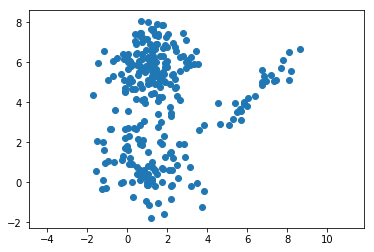

In [3]:
plt.scatter(x[:,0],x[:,1])
plt.axis('equal')
plt.show()

In [4]:
def e_step(x,pi,mu,sigma,n_mixtures=3):
    """ calculates the probability that a given datapoint belongs to a particular mixture
    """
    assignments = []
    for x_i in x:
        assignment_probs = []
        for i in range(n_mixtures):
            r_i = multivariate_normal.pdf(x_i,mean=mu[i],cov=sigma[i])*pi[i] # unscaled assignment prob. for mixture i
            assignment_probs.append(r_i)
            
        assignment_probs = np.array(assignment_probs)
        assignment_probs /= np.sum(assignment_probs)
        assignments.append(assignment_probs)
        
    return np.vstack(assignments)

In [5]:
def m_step(x,assignment_weights,pi,mu,sigma,n_mixtures=3):
    """ updates the parameters: pi,mu,sigma
    """    
    # updating pi:
    pi = np.sum(assignment_weights,axis=0)/len(x)
    
    # updating mu:
    for i in range(n_mixtures):
        mu[i] = (1/np.sum(assignment_weights[:,i]))*np.sum(np.expand_dims(assignment_weights[:,i],axis=-1)*x,axis=0)
        
    # updating sigma:
    for i in range(n_mixtures):
        components = []
        for j,x_i in enumerate(x):
            diff = np.expand_dims(x_i-mu[i],axis=0)
            component_sigma = assignment_weights[j,i]*diff.T.dot(diff)
            components.append(component_sigma)
        sigma[i] = (1/np.sum(assignment_weights[:,i]))*np.sum(np.stack(components),axis=0)
    
    return pi,mu,sigma

In [6]:
def loss_function(x,assignment_weights,pi,mu,sigma,n_mixtures=3):
    """ log-likelihood
    """
    total_loss = 0
    for j,x_i in enumerate(x):
        for i in range(n_mixtures):
            if assignment_weights[j,i]!=0: # 0*log(0) evaluated to be 0
                total_loss += assignment_weights[j,i]*(np.log(multivariate_normal.pdf(x_i,mean=mu[i],cov=sigma[i])+1e-20)+np.log(pi[i]))
                total_loss -= assignment_weights[j,i]*np.log(assignment_weights[j,i])
    return total_loss

In [7]:
def get_colors(hard_mixture_assignments):
    """ returns colors per mixture assignment for plotting
    """
    colors = []
    for assignment in hard_mixture_assignments:
        if assignment == 0:
            colors.append('c')
        elif assignment == 1:
            colors.append('m')
        else:
            colors.append('r')
    return colors

In [8]:
def run_em_algorithm(x,n_steps=15,n_inits=5,n_mixtures=3):
    """ runs EM algorithm
    """
    best_run_assignments = None
    best_run_loss = float("-inf")
    
    for _ in range(n_inits):
        pi = np.ones((3))/3
        mu = np.random.randn(3,2)
        sigma = np.zeros((3,2,2))
        sigma[...] = np.identity(2)
        
        prev_loss = float("-inf")
        for _ in range(n_steps):
            assignment_weights = e_step(x,pi,mu,sigma,n_mixtures)
            pi,mu,sigma = m_step(x,assignment_weights,pi,mu,sigma,n_mixtures)
            loss = loss_function(x,assignment_weights,pi,mu,sigma,n_mixtures)
            assert(loss>prev_loss) # check constraint
            prev_loss = loss
            
        if loss > best_run_loss:
            best_run_loss = loss
            hard_mixture_assignments = np.argmax(assignment_weights,axis=-1)
            best_run_assignments = hard_mixture_assignments
            
    return best_run_assignments,best_run_loss

In [9]:
best_run_assignments,best_run_loss = run_em_algorithm(x)

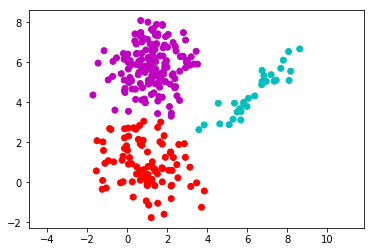

In [10]:
plt.scatter(x[:,0],x[:,1],color=get_colors(best_run_assignments))
plt.axis('equal')
plt.show()